## Analysis of Atop logs (Advanced System & Process Monitor).
Main aim of which is to identify processes and types of processes with the most resource utilization on the local machine.  
And as a practice of data wrangling with pandas.  
(several functions are moved out into its own files to not clog this notebook, see `helpers.py` and `atop_reader.py`)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

### Preparing the data.

Loading in:

In [2]:
# list all gathered logs
!ls /var/log/atop

atop_20171021  atop_20171028  atop_20171107  atop_20171114  dummy_after
atop_20171022  atop_20171029  atop_20171108  atop_20171115  dummy_after.2
atop_20171023  atop_20171030  atop_20171109  atop_20171116  dummy_before
atop_20171024  atop_20171031  atop_20171110  atop_20171117  dummy_before.2
atop_20171025  atop_20171101  atop_20171111  atop_20171118
atop_20171026  atop_20171105  atop_20171112  atop_20171119
atop_20171027  atop_20171106  atop_20171113  daily.log


In [3]:
# logs files are stored in binary
# preview one such file converted to plain text

# -r read a file, -P fields to show (ALL for all fields)
!atop -r '/var/log/atop/atop_20171025' -P ALL | head

RESET
CPU archbox 1508875204 2017/10/25 00:00:04 536500 100 4 3018178 12555290 35839 77769710 1124459 0 425970 0 0 8398 100
cpu archbox 1508875204 2017/10/25 00:00:04 536500 100 0 789119 3265103 10320 43934612 821536 0 174456 0 0 2400 100
cpu archbox 1508875204 2017/10/25 00:00:04 536500 100 1 709432 3109511 8191 11263899 81176 0 81478 0 0 1199 100
cpu archbox 1508875204 2017/10/25 00:00:04 536500 100 2 800629 3212050 8883 11213234 140877 0 94005 0 0 2399 100
cpu archbox 1508875204 2017/10/25 00:00:04 536500 100 3 718996 2968626 8443 11357963 80870 0 76029 0 0 2400 100
CPL archbox 1508875204 2017/10/25 00:00:04 536500 4 0.65 0.18 0.11 1207524268 459964503
MEM archbox 1508875204 2017/10/25 00:00:04 536500 4096 1526447 199162 179169 27373 28329 257 17248 0 73585 15322 1218 2097152 0 0
SWP archbox 1508875204 2017/10/25 00:00:04 536500 4096 1561599 1405047 0 2962326 2324822
PAG archbox 1508875204 2017/10/25 00:00:04 536500 4096 43081909 0 0 132822 564568


Each line in the output is a record. First field in the record is the record type.  
I have written a short library to work over this output.

In [4]:
from atop_reader import list_atop_logs, iterate_atop_records, to_pandas, GENERIC_FIELDS
from helpers import humansize # simple 1048576 -> '1.0MiB' converter

# dataframe might grows relatively large in the momory and take a while to process
# so I'm going to only grab a few ones from the middle
files = list_atop_logs(root='/var/log/atop')[-15:-11]

sys_tables = 'CPU CPL MEM SWP NET'.split() # overall system readings
ps_tables = 'PRG PRC PRD PRM'.split() # per process readings
dsk_table = 'DSK' # per disk device readings

needed_types = sys_tables + ps_tables + [dsk_table]

# the following call assumes a few things about installed atop,
# on different machines it may be necessary to provide a custom schema
# (see `help(atop_reader)` and `atop_reader.ATOP_SCHEMA`)
iterator = iterate_atop_records(files, record_types=needed_types)
dataframes = to_pandas(iterator, progress=lambda i: print('reading:', files[i]))

for type_ in needed_types:
    print(type_, humansize(dataframes[type_].memory_usage(deep=True).sum()))
    
dataframes['CPU'].head()

reading: /var/log/atop/atop_20171105
reading: /var/log/atop/atop_20171106
reading: /var/log/atop/atop_20171107
reading: /var/log/atop/atop_20171108
CPU 153.8KiB
CPL 123.9KiB
MEM 162.4KiB
SWP 123.9KiB
NET 165.6KiB
PRG 435.2MiB
PRC 307.0MiB
PRD 415.3MiB
PRM 327.9MiB
DSK 218.5KiB


,type,epoch,sample_interval,sample_n,boot_n,log_file,cpu_tot,processors,cpu_sys,cpu_usr,cpu_niced,cpu_idle,cpu_wait,cpu_irq,cpu_softirq,cpu_steal,cpu_guest,freq,freq_pct
0,CPU,1509846129,24,0,0,/var/log/atop/atop_20171105,100.0,4.0,518.0,204.0,0.0,4973.0,3567.0,0.0,10.0,0.0,0.0,9576.0,100.0
1,CPU,1509846729,600,1,0,/var/log/atop/atop_20171105,100.0,4.0,5212.0,33902.0,65.0,162926.0,35275.0,0.0,861.0,0.0,0.0,9576.0,100.0
2,CPU,1509847329,600,2,0,/var/log/atop/atop_20171105,100.0,4.0,5602.0,27376.0,272.0,193142.0,10353.0,0.0,989.0,0.0,0.0,9576.0,100.0
0,CPU,1509847929,600,3,0,/var/log/atop/atop_20171105,100.0,4.0,7496.0,37420.0,156.0,174910.0,14468.0,0.0,1685.0,0.0,0.0,9576.0,100.0
1,CPU,1509848529,600,4,0,/var/log/atop/atop_20171105,100.0,4.0,2260.0,4245.0,9.0,224516.0,6224.0,0.0,280.0,0.0,0.0,9576.0,100.0


Cleaning and munging:

In [5]:
# going to drop per thread records on process dataframes
for type_ in ps_tables:
    dataframes[type_] = dataframes[type_].query('is_process == "y"')

In [6]:
# prepend record type name into each column name
# like CPL_load_avg15, NET_udp_rcv...

# on generic fields just capitalize the first letter

for type_, df in dataframes.items():
    df.rename(columns=lambda col: (col[0].title()+col[1:]) if col in GENERIC_FIELDS else f'{type_}_{col}',
              inplace=True)

In [7]:
# merge similar dataframes for convenience
df_sys = pd.concat([dataframes[t].reset_index(drop=True) for t in sys_tables], axis=1)
df_ps = pd.concat([dataframes[t].reset_index(drop=True) for t in ps_tables], axis=1)
df_dsk = dataframes[dsk_table]

# remove duplicated generic columns after merge
df_sys = df_sys.iloc[:,np.unique(df_sys.columns, return_index=True)[1]]
df_ps = df_ps.iloc[:,np.unique(df_ps.columns, return_index=True)[1]]

In [8]:
# drop records with irregular sample intervals
# they skew the results and a pain to work with

median = df_sys.Sample_interval.median()
def drop_irregulars(df):
    return df[(df.Sample_interval - median).abs() < 50]

df_sys = drop_irregulars(df_sys)
df_dsk = drop_irregulars(df_dsk)
df_ps = drop_irregulars(df_ps)

In [9]:
# convert Epoch field to a datetime index (local timezone)
from dateutil.tz import tzlocal

tz = tzlocal()

for df in [df_sys, df_ps, df_dsk]:
    df.set_index('Epoch', inplace=True)
    df.index = pd.to_datetime(df.index, unit='s', utc=True).tz_convert(tz)

In [10]:
df_sys.head()

,Boot_n,CPL_ctx_switches,CPL_interrupts,CPL_load_avg1,CPL_load_avg15,CPL_load_avg5,CPL_processors,CPU_cpu_guest,CPU_cpu_idle,CPU_cpu_irq,...,NET_udp_snt,SWP_NONE,SWP_committed_limit,SWP_page_size,SWP_size_committed,SWP_size_free,SWP_size_swp,Sample_interval,Sample_n,Type
Epoch,,,,,,,,,,,,,,,,,,,,,
2017-11-05 05:52:09+04:00,0,2018753.0,776273.0,0.92,1.07,1.33,4.0,0.0,162926.0,0.0,...,762.0,0.0,2324805.0,4096.0,1775844.0,1561599.0,1561599.0,600,1,CPU
2017-11-05 06:02:09+04:00,0,2476694.0,910295.0,1.95,0.98,1.17,4.0,0.0,193142.0,0.0,...,15055.0,0.0,2324805.0,4096.0,1738538.0,1561599.0,1561599.0,600,2,CPU
2017-11-05 06:12:09+04:00,0,3657707.0,1587428.0,0.67,1.28,1.38,4.0,0.0,174910.0,0.0,...,155025.0,0.0,2324805.0,4096.0,1893924.0,1561599.0,1561599.0,600,3,CPU
2017-11-05 06:22:09+04:00,0,1254722.0,729200.0,0.11,0.77,0.35,4.0,0.0,224516.0,0.0,...,240002.0,0.0,2324805.0,4096.0,1888404.0,1561599.0,1561599.0,600,4,CPU
2017-11-05 06:32:09+04:00,0,2562028.0,711372.0,0.88,0.62,0.53,4.0,0.0,209144.0,0.0,...,340.0,0.0,2324805.0,4096.0,1945201.0,1561599.0,1561599.0,600,5,CPU


### Review and analysis.

In [11]:
# I will define a plot decorator that graphs nightime, reboots
# and sets an easily readable datetime ticks on the x axis

import matplotlib.patches as patches
from matplotlib.dates import DateFormatter, HourLocator

# sleeping hours 
sleep_at = 22
wake_at = 7

# timestamps of reboots
reboots = df_sys.groupby('Boot_n').apply(lambda g: g.iloc[0].name)

def decor(ax=None):
    ax = ax or plt.gca()
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()

    # draw nightime
    day_fraction = (sleep_at/24)
    start = int(x1) - 1 + day_fraction
    length = 1 - day_fraction + (wake_at/24)
    while start < x2:
        rect = patches.Rectangle((start, y1), length, y2-y1, alpha=.07, color='k', linewidth=0)
        ax.add_patch(rect)
        start += 1
    
    # draw reboots
    for reboot in reboots:
        ax.axvline(reboot, linestyle='--', linewidth=1, alpha=.4, c='k')
    
    # setup time axis
    ax.xaxis.set_major_formatter(DateFormatter('%R\n%a'))
    ax.xaxis.set_major_locator(HourLocator(0))
    ax.xaxis.set_minor_formatter(DateFormatter('%R'))
    ax.xaxis.set_minor_locator(HourLocator([6,12,18]))
    plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center')
    ax.xaxis.label.set_visible(False)

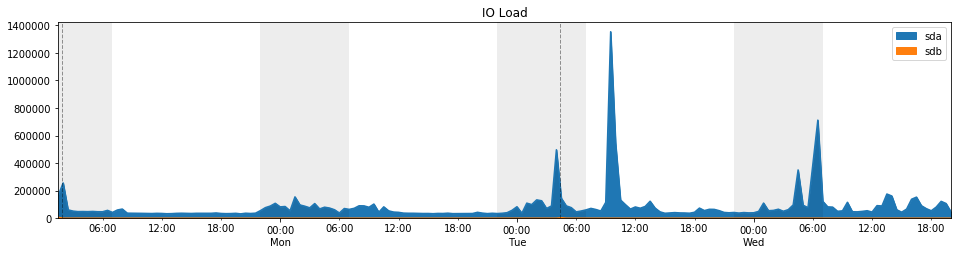

In [12]:
# let's see usage of each disk for the given period
summed_io = df_dsk.groupby('DSK_name').resample('30min').sum()
fig = plt.figure(figsize=(16, 4))
for device in summed_io.index.levels[0]:
    ax = summed_io.loc[device]['DSK_ms_spent'].plot.area(fig=fig, title='IO Load', label=device)
ax.legend()
decor()
plt.show()

Seems like secondary drive readings are largely irrelevant in comparison to the system drive.

Let's now draw overall resource utilization graphs.

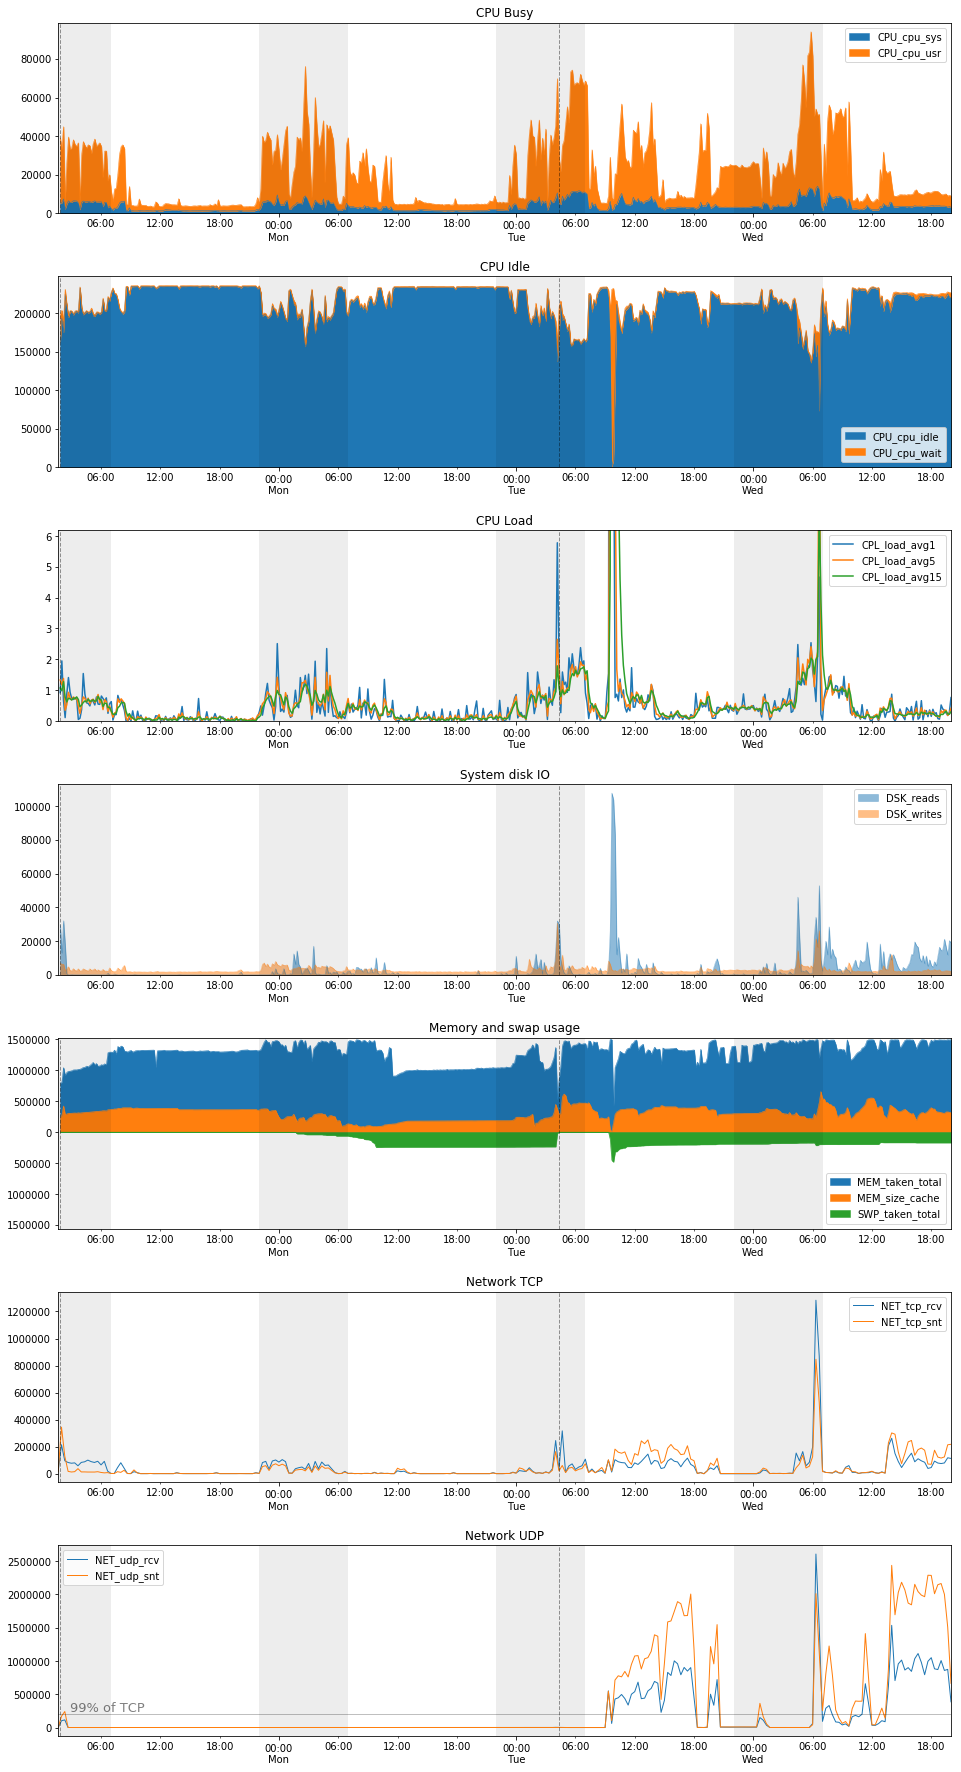

In [13]:
num_plots = 7
fig, axes = plt.subplots(num_plots, 1, figsize=(16, 5*num_plots), sharex=True)
fig.subplots_adjust(hspace=.33)
lw = .5
axesi = iter(axes)

# cpu

df_sys[['CPU_cpu_sys', 'CPU_cpu_usr']].plot.area(ax=next(axesi), title='CPU Busy', linewidth=lw)

df_sys[['CPU_cpu_idle', 'CPU_cpu_wait']].plot.area(ax=next(axesi), title='CPU Idle', linewidth=lw)

fields = ['CPL_load_avg1', 'CPL_load_avg5', 'CPL_load_avg15']
df_sys[fields].plot.line(ax=next(axesi), title='CPU Load',
                         ylim=(0, df_sys.CPL_load_avg15.quantile(.99)))

# disk

df_dsk_main = df_dsk[df_dsk.DSK_name == 'sda']
df_dsk_main[['DSK_reads', 'DSK_writes']] \
    .plot.area(ax=next(axesi), title='System disk IO', linewidth=lw, stacked=False)

# memory and swap (two sided area plot)

from matplotlib.ticker import FuncFormatter

ax = next(axesi)

taken = df_sys.MEM_size_phys - df_sys.MEM_size_free
taken.plot.area(ax=ax, label='MEM_taken_total', title='Memory and swap usage', linewidth=lw)
df_sys.MEM_size_cache.plot.area(ax=ax, linewidth=lw)

taken = -(df_sys.SWP_size_swp - df_sys.SWP_size_free)
taken.plot.area(ax=ax, label='SWP_taken_total', linewidth=lw,
                ylim=(-df_sys.SWP_size_swp.max(), df_sys.MEM_size_phys.max()))

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(abs(x))))
ax.legend()

# network

df_sys[['NET_tcp_rcv', 'NET_tcp_snt']] \
    .resample('20min').sum() \
    .plot.line(ax=next(axesi), linewidth=1, title='Network TCP')

ax = next(axesi)

df_sys[['NET_udp_rcv', 'NET_udp_snt']] \
    .resample('20min').sum() \
    .plot.line(ax=ax, linewidth=1, title='Network UDP')

# show comparison with tcp traffic on udp plot
tcp99 = df_sys[['NET_tcp_rcv', 'NET_tcp_snt']].quantile(.99).max()
ax.axhline(tcp99, linewidth=lw, color='k', alpha=.5)
ax.text(ax.get_xlim()[0]+.05, tcp99+tcp99*.15, '99% of TCP', color='k', alpha=.5, size=13)

for ax in axes:
    decor(ax)
    # sharex param hides ticklabels on all but the bottommost, this will revert it
    ax.tick_params(labelbottom=True, which='both')
    
plt.show()

These spikes in CPU load seem to be due to IO hogs as the IO graph and CPU_cpu_wait portion indicate.  
I should investigate specifically these segments more later.

To work with the process dataframe I need to properly identify processes.  
Most identifiers have problems — PIDs change over programs restarts, names are too generic, command line differs across restarts and not always present.  
I'll try to use process path in the process tree which might be a more descriptive attribute.

In [14]:
from helpers import generate_paths
# this functions groups by sample_n, for each group produces list of paths
# and then joins them together

result = generate_paths(df_ps)
result.sample(5)

0.98 done


2017-11-07 22:50:56+04:00    chromium—chromium—chrome-sandbox—chromium—xfce...
2017-11-06 23:20:03+04:00                                   scsi_eh_0—kthreadd
2017-11-08 20:10:06+04:00    gpu-temp—conky—xfce4-session—sh—xinit—startx—z...
2017-11-07 16:20:56+04:00                   python—code—code—code—code—systemd
2017-11-06 11:40:03+04:00    nvidia-settings—gpu-temp—conky—xfce4-session—s...
dtype: object

In [15]:
# and merge it into process dataframe
df_ps['PRG_tree'] = result
df_ps[['PRG_name', 'PRG_tree', 'PRG_cmd']].sample(5)

,PRG_name,PRG_tree,PRG_cmd
Epoch,,,
2017-11-08 07:10:06+04:00,gvfsd-fuse,gvfsd-fuse—systemd—systemd,/usr/lib/gvfs/gvfsd-fuse /run/user/1000/gvfs -...
2017-11-05 18:42:09+04:00,chromium,chromium—chromium—chromium—chrome-sandbox—chro...,/usr/lib/chromium/chromium --type=renderer --f...
2017-11-08 08:30:06+04:00,readlink,readlink—bash—bash—panel-17-whiske—xfce4-panel...,
2017-11-05 12:52:09+04:00,grep,grep—gpu-temp—conky—xfce4-session—sh—xinit—sta...,
2017-11-06 02:00:03+04:00,grep,grep—gpu-temp—conky—xfce4-session—sh—xinit—sta...,


In [16]:
# define a few convenience fields
df_ps['PRC_cpu_taken'] = df_ps.PRC_cpu_usr + df_ps.PRC_cpu_sys
df_ps['PRD_io_taken'] = df_ps.PRD_reads + df_ps.PRD_writes

I will now group processes by paths. One problem with it is the path also not unique (multiple processes can have the same path at the same time), so we're going to grab only the max readings per sample.

In [17]:
df = df_ps.reset_index()
groupby = ['PRG_tree', 'Sample_n']
agg = {col: ('max' if d.kind in ('f', 'i') else 'first') for col, d in df.dtypes.items()}
df = df.groupby(groupby).agg(agg).reset_index(drop=True).set_index('Epoch')
ps_groups = df.groupby('PRG_tree')

Let's take a look at which processes take the most memory overall.

In [18]:
print('Memory:')
ps_groups['PRM_mem_res_size'].agg(['mean', 'max', 'sum']) \
    .sort_values('sum', ascending=False).head(10) \
    .applymap(lambda x: humansize(x*1024))
# 'sum' here only makes sense for sorting

Memory:


,mean,max,sum
PRG_tree,,,
python3—zsh—xfce4-terminal—xfsettingsd—systemd,922.9MiB,1.1GiB,444.3GiB
chromium—chromium—chromium—chrome-sandbox—chromium—xfce4-panel—systemd,437.2MiB,995.4MiB,230.1GiB
chromium—xfce4-panel—systemd,305.8MiB,380.4MiB,161.0GiB
ipython—screen—systemd,162.0MiB,1.5GiB,85.4GiB
chromium—chromium—xfce4-panel—systemd,128.5MiB,235.0MiB,67.7GiB
skype—xfce4-session—sh—xinit—startx—zsh—login—systemd,96.3MiB,199.4MiB,50.7GiB
code—code—code—systemd,179.9MiB,224.7MiB,48.7GiB
Xorg—xinit—startx—zsh—login—systemd,75.7MiB,98.4MiB,39.9GiB
python—code—code—code—code—systemd,133.7MiB,470.7MiB,35.9GiB


Now let's look at this data in a more descriptive form of a heatmap.  
I wrote a function that graphs a heatmap stripes for a list of lists of values.  

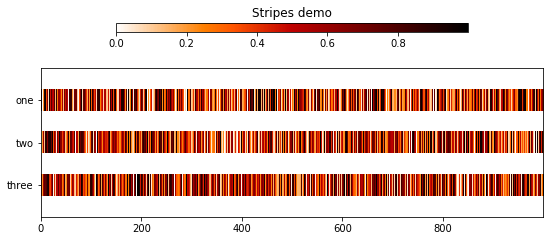

In [19]:
from helpers import stripes

plt.figure(figsize=(9, 4))
stripes(np.random.rand(3, 1000), labels=['one', 'two', 'three'], title='Stripes demo')
plt.show()

In [20]:
from helpers import stripes_for_tseries
# wrapper around stripes that allows to plot tseries indexed data

def plot_groups(col, sort_by, limit, **kw):
    sorted_names = ps_groups[col].agg(sort_by).sort_values(ascending=False) \
                    .head(limit).index.tolist()

    # split and shrink process paths to fit on graph
    labels = []
    for label in sorted_names:
        a, _, b = label.partition('—')
        labels.append(f'{a}\n{b[:20]}' if b else a)

    values = [ps_groups.get_group(name)[col] for name in sorted_names]
    fig, (main_ax, cb_ax, extra_ax) = stripes_for_tseries(values, width=14, freq='10min',
                                                          align_tolerance='5min', labels=labels, **kw)
    return extra_ax

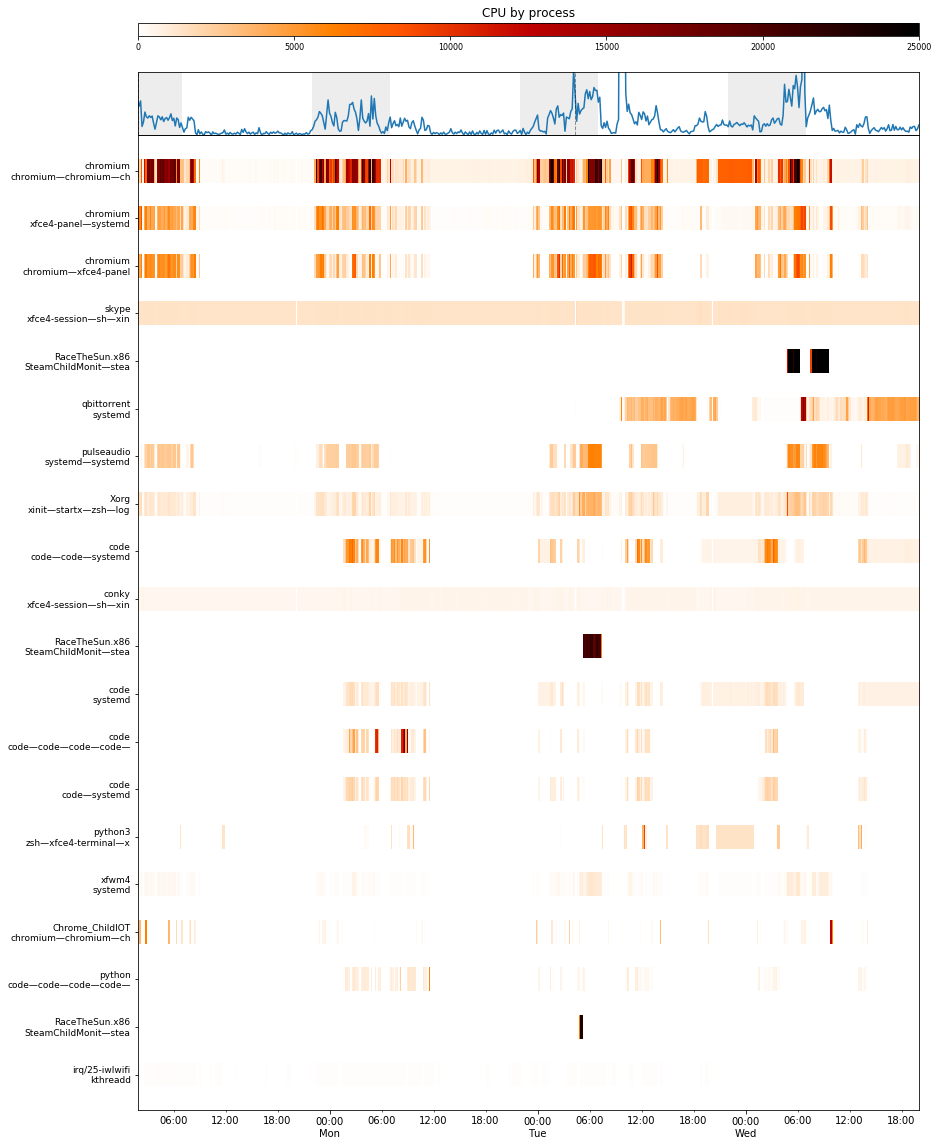

In [21]:
extra_ax = plot_groups('PRC_cpu_taken', 'sum', 20, title='CPU by process', vmax=25000)
extra_ax.plot(df_sys.index, df_sys.CPU_cpu_wait)
extra_ax.set_ylim((0, df_sys.CPL_load_avg5.quantile(.99)))
decor(extra_ax)

Unsurprisingly CPU is mostly occupied by chromium and vscode (so also chromium).  
Let's see if IO can explain the high peak near the end.

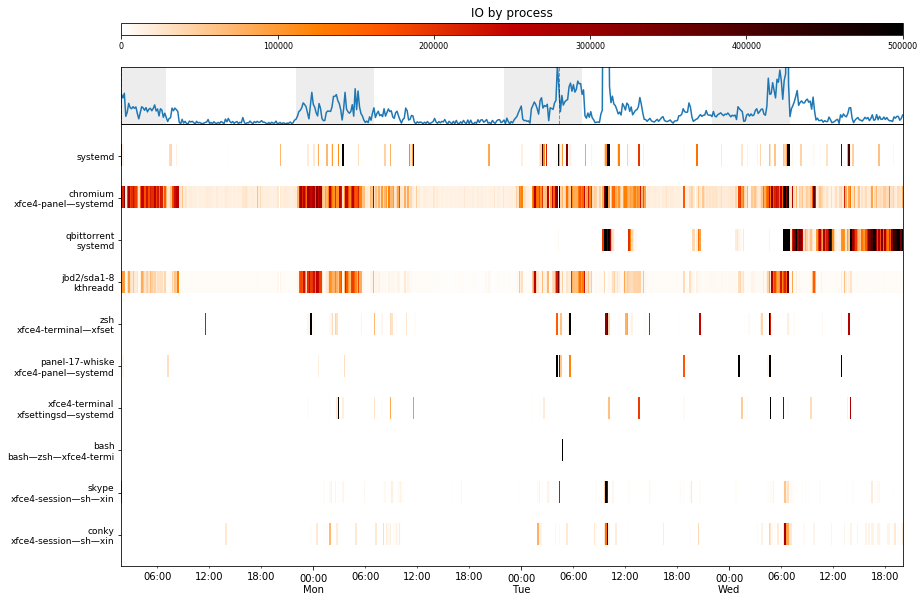

In [22]:
extra_ax = plot_groups('PRD_io_taken', 'sum', 10, vmax=500000, title='IO by process')
extra_ax.plot(df_sys.index, df_sys.CPL_load_avg5)
extra_ax.set_ylim((0, df_sys.CPL_load_avg5.quantile(.99)))
decor(extra_ax)

It does seem like everyone is doing some high io during that period. System graph showed a high drop in memory and increase in swap usage, not sure what could've caused that.

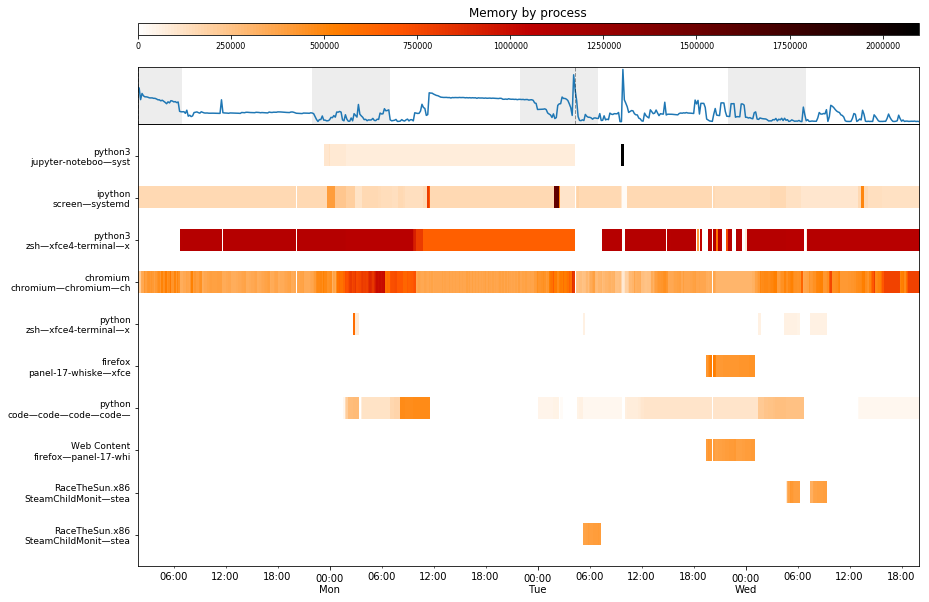

In [23]:
extra_ax = plot_groups('PRM_mem_res_size', 'max', 10, vmax=1024*1024*2, title='Memory by process')
extra_ax.plot(df_sys.index, df_sys.MEM_size_free)
decor(extra_ax)

It looks like I had jupyter-notebook eat up a large chunk of my memory during the peak, so that's likely the explanation here.